In [47]:
import cv2
import glob
import os
from matplotlib import pyplot as plt
import numpy as num
import uuid

In [48]:
minimumNumberOfGoodMatches = 50

mySIFTInstance = cv2.SIFT_create()
bf = cv2.BFMatcher()

class SIFTImage:
    def __init__(self, image):
        self.image = image

        keypoints, descriptors = mySIFTInstance.detectAndCompute(image, None)
        self.keypoints = keypoints
        self.descriptors = descriptors

        # self.keyPointImage = cv2.drawKeypoints(cv2.cvtColor(image, cv2.COLOR_BGR2GRAY), keypoints, None)

        self.id = uuid.uuid1()

    def __eq__(self, other):
        """Overrides the default implementation"""
        if isinstance(other, SIFTImage):
            return self.id == other.id
        return False

class MatchedImagePair:
    def __init__(self, siftImage1, siftImage2):
        self.siftImage1 = siftImage1
        self.siftImage2 = siftImage2

        matches = bf.knnMatch(siftImage1.descriptors, siftImage2.descriptors, k=2)

        goodMatches = []
        #I then perform Lowe's ratio test on all matches to only get the quality matches
        for m,n in matches:
            if m.distance < 0.8*n.distance:
                goodMatches.append(m)

        self.goodMatches = goodMatches

        print(len(goodMatches))
        # matched image pair must have at least the numbr of minimumNumberOfGoodMatches 
        # for it to be deemed a good match
        self.meetsMatchMatric = len(goodMatches) >= minimumNumberOfGoodMatches

def matchedPairContains(matchedPairs, image1, image2):
    for matchedPair in matchedPairs:
        if (matchedPair.siftImage1 == image1 and matchedPair.siftImage2 == image2) or (matchedPair.siftImage1 == image2 and matchedPair.siftImage2 == image1):
            return True
    return False

# function that filters vowels
def filterPoorMatches(variable):
    if (variable.meetsMatchMatric):
        return True
    else:
        return False


In [49]:
# 1. Match Features

#The first step is to extract features from the images, and automatically establish feature correspondences between image pairs.

# The starting point is an unordered set of N images. The objective of this step is to extract features from each image, 
# and establish which (if any) of the N-1 other images contain a sufficient number of good matches so as to indicate that 
# the two images partially overlap. You can use any feature that you prefer (e.g. ORB, SIFT, SURF) or some combination thereof.
# You will need to develop a match metric that can be used to discriminate between good and bad image matches. For example, 
# this match metric could take the number of matching features between images into account, as well as the quality of their 
# match. Keep in mind that each image will only overlap with a small number of other images in the set, so ideally this match 
# metric will score high for the images that do have overlap, and low otherwise.

imagePath = os.path.expanduser('~/Autostich-Maly/D1/Images/StJamesTest/*.jpg')  #CAN CHANGE DEPENDING ON TEST IMAGES

#does it make sense to convert to b&w?
images = [cv2.imread(file) for file in glob.glob(imagePath)]

siftImages = []

for image in images:
    (keypoints, descriptors) = mySIFTInstance.detectAndCompute(image, None)

    siftImage = SIFTImage(image)

    siftImages.append(siftImage)

#This is test code to ensure keypoints are added correctly
# testSiftImage = siftImages[0].image
# testSiftImageKeyPoint = siftImages[0].keypoints

# imageHeight, imageWidth, imageChannels = testSiftImage.shape
# blankImage = num.zeros((imageHeight, imageWidth, imageChannels), num.uint8)
# testSiftImageOutput = cv2.drawKeypoints(testSiftImage, testSiftImageKeyPoint, blankImage)
# plt.imshow(testSiftImageOutput)

matchedPairs = []

count = 0 

for testSiftImage in siftImages:
    for siftImage in siftImages:
        if (siftImage == testSiftImage): 
            continue

        if (matchedPairContains(matchedPairs, siftImage, testSiftImage)):
            continue
        
        matchedPairs.append(MatchedImagePair(siftImage, testSiftImage))

# matchedPair = matchedPairs[0]

# matchesImage = cv2.drawMatchesKnn(
#     matchedPair.siftImage1.image, 
#     matchedPair.siftImage1.keypoints, 
#     matchedPair.siftImage2.image, 
#     matchedPair.siftImage2.keypoints,
#     matchedPair.matches, 
#     None
# )

# plt.imshow(matchesImage)

goodMatchPairs = list(filter(filterPoorMatches, matchedPairs))

8423


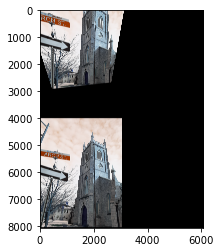

In [72]:
# 2. Estimate Transformation

#The second step is to use these correspondences to estimate transformations between each image, and establish the most likely transformations between the image pairs.

# For those image pairs that have a high enough match metric score from Step 1, calculate the transformation between them.



for goodMatchPair in goodMatchPairs:
    image1Keypoints = goodMatchPair.siftImage1.keypoints
    image2Keypoints = goodMatchPair.siftImage2.keypoints

    ref_pts = num.float32([image1Keypoints[m.queryIdx].pt for m in goodMatchPair.goodMatches]).reshape(-1, 1, 2)
    tgt_pts = num.float32([image2Keypoints[m.trainIdx].pt for m in goodMatchPair.goodMatches]).reshape(-1, 1, 2)

    [tr_mat, _] = cv2.findHomography(ref_pts, tgt_pts)

    image1 = goodMatchPair.siftImage1.image

    img_ref_tr = cv2.warpPerspective(image1, tr_mat, (image1.shape[1], image1.shape[0]))

    plt.imshow(img_ref_tr)



# 3. Merge Images

# The third step is to apply these transformations to compose a single merged composite image from all images.

# Apply the transformations calculated in Step 2, and create and store a single merged image from the N images in the set. 
# Apply both geometric and radiometric transformations, so that the resulting merged image appears relatively seamless.


# blank_image = num.zeros((height,width,3), np.uint8)

# for index, matchPair in enumerate(goodMatchPairs):
#     if index == 0:
#         firstImage = 
#         #plot image
#         height = img.shape[0]
#         width = img.shape[1]
#         channels = img.shape[2]

#         plt.imshow(matchPair.siftImage1.image)
#     else: 
#         continue?